In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import gc
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

PATH = '../'

In [2]:
%%time
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'Track 1/test.csv')
submission = pd.read_csv(PATH + 'Track 1/submission.csv')

CPU times: user 5.27 s, sys: 365 ms, total: 5.64 s
Wall time: 1.95 s


In [3]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs(satellite_predicted_values - satellite_true_values) / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values)))

In [4]:
training_columns = ['epoch', 'sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
prediction_columns = ['x','y','z','Vx', 'Vy', 'Vz']
X = train.loc[:, training_columns]
y = train.loc[:, prediction_columns]
Xtest = test.loc[:, training_columns]

In [5]:
def extractTimeFeats(data):
    timeFeats = data['epoch'].apply(lambda x: str(x).split('T')[1].split('.')[0].split(':')).values
    h,m,s = [],[],[]
    for feat in timeFeats:
        h.append(feat[0]); m.append(feat[1]); s.append(feat[2])
    return h,m,s

In [6]:
X['r'] = np.sqrt(X.x_sim**2 + X.y_sim**2 + X.z_sim**2)
Xtest['r'] = np.sqrt(Xtest.x_sim**2 + Xtest.y_sim**2 + Xtest.z_sim**2)
y['r'] = np.sqrt(y.x**2 + y.y**2 + y.z**2)

X['phi'] = np.arctan(X.y_sim/X.x_sim)
Xtest['phi'] = np.arctan(Xtest.y_sim/Xtest.x_sim)
y['phi'] = np.arctan(y.y/y.x)

X['theta'] = np.arccos(X.z_sim/X.r)
Xtest['theta'] = np.arccos(Xtest.z_sim/Xtest.r)
y['theta'] = np.arccos(y.z/y.r)


X['Vr'] = np.sqrt(X.Vx_sim**2 + X.Vy_sim**2 + X.Vz_sim**2)
Xtest['Vr'] = np.sqrt(Xtest.Vx_sim**2 + Xtest.Vy_sim**2 + Xtest.Vz_sim**2)
y['Vr'] = np.sqrt(y.Vx**2 + y.Vy**2 + y.Vz**2)

X['Vphi'] = np.arctan(X.Vy_sim/X.Vx_sim)
Xtest['Vphi'] = np.arctan(Xtest.Vy_sim/Xtest.Vx_sim)
y['Vphi'] = np.arctan(y.Vy/y.Vx)

X['Vtheta'] = np.arccos(X.Vz_sim/X.Vr)
Xtest['Vtheta'] = np.arccos(Xtest.Vz_sim/Xtest.Vr)
y['Vtheta'] = np.arccos(y.Vz/y.Vr)

In [7]:
h,m,s = extractTimeFeats(X)
X.loc[:, 'h'] = list(map(int, h)); X.loc[:, 'm'] = list(map(int, m)); X.loc[:, 's'] =list(map(int, s))
X.drop(columns = 'epoch', inplace = True)

h,m,s = extractTimeFeats(Xtest)
Xtest.loc[:, 'h'] = list(map(int, h)); Xtest.loc[:, 'm'] = list(map(int, m)); Xtest.loc[:, 's'] = list(map(int, s))
Xtest.drop(columns = 'epoch', inplace = True)

In [8]:
X.head()

,sat_id,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,r,phi,theta,Vr,Vphi,Vtheta,h,m,s
0,0,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,26096.521772,-0.978364,2.489481,4.404340,1.336658,2.048315,0,0,0
1,0,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,26703.386480,-0.154996,2.729985,4.324766,1.499788,1.713827,0,46,43
2,0,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,28351.260474,0.764843,2.598448,4.119305,-1.502975,1.395411,1,33,26
3,0,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,30659.611188,1.153140,2.314850,3.853846,-1.362770,1.108653,2,20,9
4,0,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,33247.520541,1.342040,2.038607,3.581697,-1.197028,0.858007,3,6,52


In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

trainSize = 0.6
submissionValid = train.copy()[['id', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
smp = []
nTargets = 6
for sat_id in tqdm(Xtest['sat_id'].unique()):
    satX = X[X['sat_id'] == sat_id]
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id]
    
    size = int(satX.shape[0] * trainSize)
#     trFeats, valFeats = satY.iloc[:size, :], satY.iloc[size:2*size, :]
    
#     Xtr= pd.concat([Xtr, (Xtr.iloc[:, 1:-3] - trFeats.mean().values)], axis = 1)
#     Xval = pd.concat([Xval, (Xval.iloc[:, 1:-3] - valFeats.mean().values)], axis = 1)
    
    ytr, yval = satY.iloc[:1*size, :-6], satY.iloc[size:, :-6]
    smp_sat = []
    for i in range(nTargets):
        model1 = CatBoostRegressor(iterations=200,
                          learning_rate=0.3,
                          depth=5,
                          verbose=False)
        Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
        model1.fit(Xtr, ytr.iloc[:, i])
        model2 = Ridge()
        model2.fit(Xtr, ytr.iloc[:, i])
        ypred = (2 * model1.predict(Xval) + model2.predict(Xval)) / 3
        smp.append(smape(ypred, yval.iloc[:, i]))
        smp_sat.append(smape(ypred, yval.iloc[:, i]))
    print(sat_id, 100*(1- np.mean(smp_sat)))
print(100*(1- np.mean(smp)))

  0%|          | 1/300 [00:02<11:01,  2.21s/it]

1 87.13701313449582


  1%|          | 2/300 [00:04<10:25,  2.10s/it]

2 95.59207406271722


  1%|          | 3/300 [00:05<09:58,  2.01s/it]

3 86.22844555242905


  1%|▏         | 4/300 [00:07<09:47,  1.98s/it]

4 81.03065259622126


  2%|▏         | 5/300 [00:09<09:57,  2.03s/it]

6 85.13090793358067


  2%|▏         | 6/300 [00:11<09:38,  1.97s/it]

9 95.74622424845033


  2%|▏         | 7/300 [00:13<09:14,  1.89s/it]

16 95.44460663189355


  3%|▎         | 8/300 [00:15<08:59,  1.85s/it]

20 66.32294097818352


  3%|▎         | 9/300 [00:16<08:49,  1.82s/it]

22 72.16478794915457


  3%|▎         | 10/300 [00:18<08:48,  1.82s/it]

24 98.71053067648022


  4%|▎         | 11/300 [00:20<08:49,  1.83s/it]

25 76.50097725069296


  4%|▍         | 12/300 [00:21<07:27,  1.56s/it]

26 80.05109271346879


  4%|▍         | 13/300 [00:23<07:41,  1.61s/it]

27 88.16255307625994


  5%|▍         | 14/300 [00:25<08:00,  1.68s/it]

28 80.68064008237185


  5%|▌         | 15/300 [00:27<08:18,  1.75s/it]

29 97.77905400783074


  5%|▌         | 16/300 [00:28<08:28,  1.79s/it]

32 87.35891417800542


  6%|▌         | 17/300 [00:30<08:38,  1.83s/it]

34 98.28814154280377


  6%|▌         | 18/300 [00:32<08:48,  1.87s/it]

35 66.50873289946509


  6%|▋         | 19/300 [00:35<09:26,  2.02s/it]

36 96.35293312060278


  7%|▋         | 20/300 [00:37<09:30,  2.04s/it]

37 14.312675003068565


  7%|▋         | 21/300 [00:39<09:11,  1.98s/it]

38 72.73337461803213


  7%|▋         | 22/300 [00:40<09:00,  1.94s/it]

39 97.50878952349832


  8%|▊         | 23/300 [00:42<08:51,  1.92s/it]

40 97.76910954039325


  8%|▊         | 24/300 [00:44<09:06,  1.98s/it]

41 86.53113093588156


  8%|▊         | 25/300 [00:46<08:54,  1.94s/it]

42 99.28087606090239


  9%|▊         | 26/300 [00:49<09:41,  2.12s/it]

44 91.98855083003906


  9%|▉         | 27/300 [00:51<09:17,  2.04s/it]

45 76.86678011390646


  9%|▉         | 28/300 [00:53<09:31,  2.10s/it]

49 96.37717675796424


 10%|▉         | 29/300 [00:55<09:33,  2.12s/it]

51 98.71791061928906


 10%|█         | 30/300 [00:57<09:09,  2.04s/it]

52 96.07288327006403


 10%|█         | 31/300 [00:59<09:19,  2.08s/it]

53 97.75830179857343


 11%|█         | 32/300 [01:01<09:23,  2.10s/it]

54 90.28594985831087


 11%|█         | 33/300 [01:03<09:07,  2.05s/it]

57 98.93170664778016


 11%|█▏        | 34/300 [01:06<09:36,  2.17s/it]

59 88.40797186877484


 12%|█▏        | 35/300 [01:08<09:29,  2.15s/it]

63 86.69579641323841


 12%|█▏        | 36/300 [01:09<08:55,  2.03s/it]

64 88.32811888002517


 12%|█▏        | 37/300 [01:12<09:18,  2.12s/it]

68 96.12689769182491


 13%|█▎        | 38/300 [01:14<08:54,  2.04s/it]

70 98.39581067421342


 13%|█▎        | 39/300 [01:16<08:59,  2.07s/it]

75 98.68033557359685


 13%|█▎        | 40/300 [01:18<09:04,  2.09s/it]

82 62.182181348520416


 14%|█▎        | 41/300 [01:20<08:48,  2.04s/it]

84 85.84014026001238


 14%|█▍        | 42/300 [01:22<08:37,  2.01s/it]

86 82.2543386982596


 14%|█▍        | 43/300 [01:24<08:38,  2.02s/it]

89 98.61067807811624


 15%|█▍        | 44/300 [01:26<08:25,  1.97s/it]

90 80.23091804807194


 15%|█▌        | 45/300 [01:29<10:00,  2.35s/it]

91 96.45000380537135


 15%|█▌        | 46/300 [01:32<10:30,  2.48s/it]

92 82.39854586330178


 16%|█▌        | 47/300 [01:35<11:25,  2.71s/it]

93 99.2164959931732


 16%|█▌        | 48/300 [01:38<11:33,  2.75s/it]

96 98.81740708419386


 16%|█▋        | 49/300 [01:41<11:34,  2.77s/it]

98 61.716779888739026


 17%|█▋        | 50/300 [01:44<12:03,  2.89s/it]

100 87.67694811387025


 17%|█▋        | 51/300 [01:47<12:04,  2.91s/it]

101 83.19741214537304


 17%|█▋        | 52/300 [01:50<12:11,  2.95s/it]

102 93.53136951849504


 18%|█▊        | 53/300 [01:53<12:08,  2.95s/it]

105 98.96777344984842


 18%|█▊        | 54/300 [01:55<11:33,  2.82s/it]

106 90.85662611359082


 18%|█▊        | 55/300 [01:58<11:27,  2.80s/it]

109 87.02103407679658


 19%|█▊        | 56/300 [02:01<11:21,  2.79s/it]

110 98.05083769031076


 19%|█▉        | 57/300 [02:03<11:08,  2.75s/it]

112 75.36754444546196


 19%|█▉        | 58/300 [02:06<11:01,  2.73s/it]

113 84.59682638086386


 20%|█▉        | 59/300 [02:09<11:32,  2.87s/it]

114 90.49664843134082


 20%|██        | 60/300 [02:11<10:18,  2.58s/it]

117 96.1847816026046


 20%|██        | 61/300 [02:13<09:48,  2.46s/it]

118 75.90257685579866


 21%|██        | 62/300 [02:15<09:16,  2.34s/it]

120 97.06054500703576


 21%|██        | 63/300 [02:19<10:11,  2.58s/it]

121 99.41041383897277


 21%|██▏       | 64/300 [02:22<11:19,  2.88s/it]

123 83.77900820628051


 22%|██▏       | 65/300 [02:26<12:34,  3.21s/it]

124 89.51724513780687


 22%|██▏       | 66/300 [02:29<12:35,  3.23s/it]

125 84.65511121055219


 22%|██▏       | 67/300 [02:33<12:28,  3.21s/it]

126 90.04087264564605


 23%|██▎       | 68/300 [02:36<12:03,  3.12s/it]

127 71.21622263929982


 23%|██▎       | 69/300 [02:38<10:56,  2.84s/it]

128 96.65448181175512


 23%|██▎       | 70/300 [02:40<09:56,  2.59s/it]

130 98.13568746770295


 24%|██▎       | 71/300 [02:42<09:04,  2.38s/it]

132 98.239695510703


 24%|██▍       | 72/300 [02:44<08:52,  2.34s/it]

133 78.3888787532827


 24%|██▍       | 73/300 [02:46<08:59,  2.38s/it]

135 94.87263808596977


 25%|██▍       | 74/300 [02:49<08:50,  2.35s/it]

138 97.95946397387219


 25%|██▌       | 75/300 [02:51<08:34,  2.29s/it]

142 94.24637332480779


 25%|██▌       | 76/300 [02:53<08:01,  2.15s/it]

143 98.7284692165941


 26%|██▌       | 77/300 [02:54<07:41,  2.07s/it]

144 96.02828198337286


 26%|██▌       | 78/300 [02:57<07:44,  2.09s/it]

145 98.58508756563279


 26%|██▋       | 79/300 [02:59<07:30,  2.04s/it]

149 91.42505787858096


 27%|██▋       | 80/300 [03:00<07:21,  2.01s/it]

151 79.6867594460593


 27%|██▋       | 81/300 [03:03<07:22,  2.02s/it]

152 98.68171695314919


 27%|██▋       | 82/300 [03:04<07:00,  1.93s/it]

153 78.84624190339873


 28%|██▊       | 83/300 [03:06<06:57,  1.92s/it]

155 93.49725293792737


 28%|██▊       | 84/300 [03:09<07:26,  2.07s/it]

156 92.03454241795967


 28%|██▊       | 85/300 [03:11<07:18,  2.04s/it]

158 97.140303119364


 29%|██▊       | 86/300 [03:13<07:23,  2.07s/it]

159 77.58016490632356


 29%|██▉       | 87/300 [03:15<07:06,  2.00s/it]

160 98.0052504974503


 29%|██▉       | 88/300 [03:16<06:54,  1.96s/it]

162 70.97098972727775


 30%|██▉       | 89/300 [03:18<06:38,  1.89s/it]

164 95.58694436257795


 30%|███       | 90/300 [03:20<06:33,  1.88s/it]

165 98.21459935671997


 30%|███       | 91/300 [03:22<07:13,  2.08s/it]

166 89.31322532025669


 31%|███       | 92/300 [03:24<06:49,  1.97s/it]

169 95.65318900665307


 31%|███       | 93/300 [03:26<06:57,  2.02s/it]

170 92.17328465211669


 31%|███▏      | 94/300 [03:28<06:53,  2.00s/it]

172 92.41859671415206


 32%|███▏      | 95/300 [03:30<06:55,  2.03s/it]

173 94.4174570488164


 32%|███▏      | 96/300 [03:32<06:39,  1.96s/it]

177 84.89309494659314


 32%|███▏      | 97/300 [03:34<06:28,  1.92s/it]

178 98.17510804552123


 33%|███▎      | 98/300 [03:36<06:38,  1.97s/it]

183 95.41049152967823


 33%|███▎      | 99/300 [03:39<07:22,  2.20s/it]

186 90.73279134077326


 33%|███▎      | 100/300 [03:41<07:12,  2.16s/it]

187 90.77815064020179


 34%|███▎      | 101/300 [03:43<06:50,  2.06s/it]

188 90.25170801441622


 34%|███▍      | 102/300 [03:45<06:36,  2.00s/it]

191 90.44388252986313


 34%|███▍      | 103/300 [03:46<06:27,  1.97s/it]

193 94.65533466596806


 35%|███▍      | 104/300 [03:48<06:15,  1.92s/it]

194 83.9959902898831


 35%|███▌      | 105/300 [03:50<06:03,  1.86s/it]

195 70.97661696396888


 35%|███▌      | 106/300 [03:52<05:57,  1.84s/it]

197 96.12466345079338


 36%|███▌      | 107/300 [03:54<05:54,  1.84s/it]

203 96.70703811429067


 36%|███▌      | 108/300 [03:55<05:52,  1.84s/it]

205 98.87489142984434


 36%|███▋      | 109/300 [03:58<06:18,  1.98s/it]

206 89.81958512217446


 37%|███▋      | 110/300 [04:00<06:42,  2.12s/it]

207 96.08843501726246


 37%|███▋      | 111/300 [04:02<06:24,  2.03s/it]

208 81.00441402789255


 37%|███▋      | 112/300 [04:05<06:50,  2.18s/it]

209 82.5075698761579


 38%|███▊      | 113/300 [04:07<06:38,  2.13s/it]

210 97.09943886021917


 38%|███▊      | 114/300 [04:09<06:24,  2.07s/it]

211 95.7229732715692


 38%|███▊      | 115/300 [04:10<06:10,  2.00s/it]

213 69.43037352715929


 39%|███▊      | 116/300 [04:12<06:00,  1.96s/it]

219 97.5269388954937


 39%|███▉      | 117/300 [04:14<05:51,  1.92s/it]

220 93.96958655475733


 39%|███▉      | 118/300 [04:16<05:42,  1.88s/it]

222 98.60294001929265


 40%|███▉      | 119/300 [04:18<05:53,  1.95s/it]

223 86.47256444884152


 40%|████      | 120/300 [04:20<05:48,  1.94s/it]

225 80.38238425500049


 40%|████      | 121/300 [04:22<05:41,  1.91s/it]

227 98.22554517857014


 41%|████      | 122/300 [04:23<05:29,  1.85s/it]

228 96.31605471291115


 41%|████      | 123/300 [04:25<05:28,  1.86s/it]

229 95.97133819931891


 41%|████▏     | 124/300 [04:27<05:25,  1.85s/it]

230 65.92961887264175


 42%|████▏     | 125/300 [04:29<05:26,  1.86s/it]

233 99.6169402431202


 42%|████▏     | 126/300 [04:31<05:32,  1.91s/it]

236 94.4621256297346


 42%|████▏     | 127/300 [04:33<05:46,  2.00s/it]

239 97.87521048604924


 43%|████▎     | 128/300 [04:36<06:09,  2.15s/it]

240 97.78155127640389


 43%|████▎     | 129/300 [04:38<05:53,  2.07s/it]

241 85.44367832213322


 43%|████▎     | 130/300 [04:39<05:40,  2.00s/it]

242 96.129712321533


 44%|████▎     | 131/300 [04:42<05:43,  2.03s/it]

243 93.91325958800424


 44%|████▍     | 132/300 [04:43<05:33,  1.99s/it]

244 82.49977301289675


 44%|████▍     | 133/300 [04:45<05:24,  1.95s/it]

245 97.91100239351039


 45%|████▍     | 134/300 [04:47<05:18,  1.92s/it]

247 74.33086530348916


 45%|████▌     | 135/300 [04:49<05:13,  1.90s/it]

248 79.84420429055665


 45%|████▌     | 136/300 [04:51<05:09,  1.89s/it]

251 86.83043754355498


 46%|████▌     | 137/300 [04:52<04:17,  1.58s/it]

252 64.90977549046313


 46%|████▌     | 138/300 [04:54<05:10,  1.92s/it]

253 45.52226223704009


 46%|████▋     | 139/300 [04:57<05:16,  1.97s/it]

254 92.02276586869561


 47%|████▋     | 140/300 [04:58<05:07,  1.92s/it]

261 98.74188155849752


 47%|████▋     | 141/300 [05:00<05:04,  1.91s/it]

263 96.69347915257845


 47%|████▋     | 142/300 [05:02<04:53,  1.86s/it]

264 73.68645572666449


 48%|████▊     | 143/300 [05:03<04:07,  1.57s/it]

265 97.60725473434366


 48%|████▊     | 144/300 [05:05<04:21,  1.68s/it]

268 85.56156618399517


 48%|████▊     | 145/300 [05:07<04:44,  1.84s/it]

270 95.27754018826589


 49%|████▊     | 146/300 [05:09<05:10,  2.01s/it]

275 87.73431165869233


 49%|████▉     | 147/300 [05:12<05:10,  2.03s/it]

277 64.84165789712956


 49%|████▉     | 148/300 [05:14<05:14,  2.07s/it]

278 91.75931943099506


 50%|████▉     | 149/300 [05:16<05:09,  2.05s/it]

281 95.55556123986385


 50%|█████     | 150/300 [05:18<05:26,  2.18s/it]

284 90.73862487866677


 50%|█████     | 151/300 [05:20<05:10,  2.08s/it]

288 97.59133374926844


 51%|█████     | 152/300 [05:22<05:14,  2.13s/it]

292 93.54980549735268


 51%|█████     | 153/300 [05:24<05:11,  2.12s/it]

293 94.67335937127811


 51%|█████▏    | 154/300 [05:27<05:10,  2.13s/it]

294 96.63003211845148


 52%|█████▏    | 155/300 [05:29<05:07,  2.12s/it]

298 98.88881225604113


 52%|█████▏    | 156/300 [05:31<05:38,  2.35s/it]

299 94.26532416737562


 52%|█████▏    | 157/300 [05:32<04:35,  1.93s/it]

301 94.40493916688489


 53%|█████▎    | 158/300 [05:34<04:32,  1.92s/it]

304 96.87013258482723


 53%|█████▎    | 159/300 [05:37<04:46,  2.03s/it]

306 95.33285983773979


 53%|█████▎    | 160/300 [05:39<04:49,  2.07s/it]

309 88.29405562432272


 54%|█████▎    | 161/300 [05:41<04:43,  2.04s/it]

310 92.75790620478398


 54%|█████▍    | 162/300 [05:47<07:33,  3.28s/it]

312 88.35529024840041


 54%|█████▍    | 163/300 [05:50<07:20,  3.22s/it]

314 96.89450043031141


 55%|█████▍    | 164/300 [05:53<07:22,  3.26s/it]

316 92.04485450736061


 55%|█████▌    | 165/300 [05:56<07:09,  3.19s/it]

319 98.5980901419197


 55%|█████▌    | 166/300 [06:00<07:20,  3.29s/it]

324 97.49715064168205


 56%|█████▌    | 167/300 [06:03<07:23,  3.33s/it]

326 93.6964628800999


 56%|█████▌    | 168/300 [06:07<07:17,  3.31s/it]

332 98.47167589515715


 56%|█████▋    | 169/300 [06:10<06:59,  3.20s/it]

333 88.41344185985037


 57%|█████▋    | 170/300 [06:13<06:54,  3.19s/it]

342 93.97505858200465


 57%|█████▋    | 171/300 [06:16<06:50,  3.19s/it]

343 97.64334712597953


 57%|█████▋    | 172/300 [06:20<07:32,  3.54s/it]

344 98.91667446345214


 58%|█████▊    | 173/300 [06:23<06:53,  3.26s/it]

347 94.08387097919274


 58%|█████▊    | 174/300 [06:26<06:41,  3.19s/it]

348 85.29574016928352


 58%|█████▊    | 175/300 [06:29<06:30,  3.12s/it]

349 97.05093510972577


 59%|█████▊    | 176/300 [06:32<06:35,  3.19s/it]

356 95.9761044665697


 59%|█████▉    | 177/300 [06:35<06:34,  3.21s/it]

357 96.06288321588917


 59%|█████▉    | 178/300 [06:40<07:03,  3.47s/it]

358 94.46697660032764


 60%|█████▉    | 179/300 [06:42<06:40,  3.31s/it]

359 97.47730808369488


 60%|██████    | 180/300 [06:45<06:20,  3.17s/it]

362 76.41139350756984


 60%|██████    | 181/300 [06:49<06:18,  3.18s/it]

363 86.53089858932104


 61%|██████    | 182/300 [06:54<07:46,  3.96s/it]

372 20.909276811428278


 61%|██████    | 183/300 [06:58<07:40,  3.93s/it]

373 96.3484225414542


 61%|██████▏   | 184/300 [07:01<07:00,  3.63s/it]

375 88.65836772748709


 62%|██████▏   | 185/300 [07:04<06:44,  3.52s/it]

377 91.3763916606343


 62%|██████▏   | 186/300 [07:07<06:06,  3.22s/it]

380 83.81461805876822


 62%|██████▏   | 187/300 [07:09<05:42,  3.03s/it]

382 89.57165525823018


 63%|██████▎   | 188/300 [07:12<05:20,  2.86s/it]

384 93.93806913302633


 63%|██████▎   | 189/300 [07:14<04:59,  2.70s/it]

385 83.9128661931334


 63%|██████▎   | 190/300 [07:17<04:46,  2.61s/it]

387 93.66982705318468


 64%|██████▎   | 191/300 [07:19<04:24,  2.42s/it]

389 96.50488183258885


 64%|██████▍   | 192/300 [07:21<04:29,  2.50s/it]

390 70.70880410578238


 64%|██████▍   | 193/300 [07:24<04:20,  2.43s/it]

391 61.87294592150436


 65%|██████▍   | 194/300 [07:27<04:38,  2.63s/it]

392 91.74636726003884


 65%|██████▌   | 195/300 [07:29<04:34,  2.62s/it]

393 98.68547866230688


 65%|██████▌   | 196/300 [07:32<04:27,  2.57s/it]

395 97.42399742754677


 66%|██████▌   | 197/300 [07:34<04:16,  2.49s/it]

396 63.87309696385258


 66%|██████▌   | 198/300 [07:36<04:02,  2.38s/it]

399 97.63069491051802


 66%|██████▋   | 199/300 [07:39<04:20,  2.58s/it]

400 98.0979250418212


 67%|██████▋   | 200/300 [07:43<04:58,  2.98s/it]

407 82.79215142372614


 67%|██████▋   | 201/300 [07:46<05:02,  3.06s/it]

409 92.37897002716844


 67%|██████▋   | 202/300 [07:49<04:49,  2.95s/it]

411 93.93277754311822


 68%|██████▊   | 203/300 [07:54<05:42,  3.53s/it]

412 96.07860247373068


 68%|██████▊   | 204/300 [07:57<05:22,  3.36s/it]

415 76.7255191422797


 68%|██████▊   | 205/300 [08:00<04:59,  3.15s/it]

416 83.82158628528047


 69%|██████▊   | 206/300 [08:03<05:02,  3.22s/it]

417 98.1330515945103


 69%|██████▉   | 207/300 [08:06<04:45,  3.07s/it]

418 83.2598966965157


 69%|██████▉   | 208/300 [08:09<05:03,  3.30s/it]

419 99.45372416706296


 70%|██████▉   | 209/300 [08:13<05:13,  3.45s/it]

422 81.92390437351908


 70%|███████   | 210/300 [08:17<05:14,  3.50s/it]

423 97.87064487686796


 70%|███████   | 211/300 [08:20<05:00,  3.38s/it]

424 97.26470294052524


 71%|███████   | 212/300 [08:23<04:50,  3.30s/it]

426 97.16606425878605


 71%|███████   | 213/300 [08:26<04:41,  3.24s/it]

428 98.82675609328962


 71%|███████▏  | 214/300 [08:29<04:22,  3.05s/it]

435 91.0922626378413


 72%|███████▏  | 215/300 [08:33<04:54,  3.47s/it]

436 98.24455672951292


 72%|███████▏  | 216/300 [08:37<04:59,  3.56s/it]

437 70.16080419290799


 72%|███████▏  | 217/300 [08:39<04:28,  3.23s/it]

438 84.6435769114002


 73%|███████▎  | 218/300 [08:42<04:11,  3.07s/it]

440 92.41942662698204


 73%|███████▎  | 219/300 [08:45<03:55,  2.90s/it]

443 78.41411191628131


 73%|███████▎  | 220/300 [08:47<03:39,  2.75s/it]

446 98.07978123153485


 74%|███████▎  | 221/300 [08:51<03:53,  2.96s/it]

448 84.6691315907381


 74%|███████▍  | 222/300 [08:54<04:11,  3.22s/it]

449 99.00436868236469


 74%|███████▍  | 223/300 [08:57<04:01,  3.14s/it]

450 80.74799866308973


 75%|███████▍  | 224/300 [09:00<03:50,  3.03s/it]

452 89.25512365002538


 75%|███████▌  | 225/300 [09:02<03:28,  2.78s/it]

454 82.39344768675923


 75%|███████▌  | 226/300 [09:05<03:15,  2.64s/it]

455 94.0484816266983


 76%|███████▌  | 227/300 [09:08<03:24,  2.80s/it]

456 94.03813906844285


 76%|███████▌  | 228/300 [09:10<03:11,  2.65s/it]

457 95.44099683935656


 76%|███████▋  | 229/300 [09:13<03:04,  2.60s/it]

460 90.65811598315223


 77%|███████▋  | 230/300 [09:15<03:04,  2.64s/it]

462 95.86723106497837


 77%|███████▋  | 231/300 [09:18<02:53,  2.52s/it]

464 91.87327250514218


 77%|███████▋  | 232/300 [09:20<02:51,  2.52s/it]

465 96.81913294470117


 78%|███████▊  | 233/300 [09:22<02:41,  2.42s/it]

466 88.84317856560962


 78%|███████▊  | 234/300 [09:26<02:56,  2.68s/it]

467 90.76238802743053


 78%|███████▊  | 235/300 [09:29<03:02,  2.80s/it]

468 91.224699202729


 79%|███████▊  | 236/300 [09:34<03:46,  3.54s/it]

470 91.63792632493687


 79%|███████▉  | 237/300 [09:37<03:31,  3.36s/it]

471 80.85789686656756


 79%|███████▉  | 238/300 [09:42<03:54,  3.79s/it]

473 37.661626636493025


 80%|███████▉  | 239/300 [09:45<03:50,  3.78s/it]

474 93.32714845490241


 80%|████████  | 240/300 [09:48<03:21,  3.35s/it]

475 96.13676952288529


 80%|████████  | 241/300 [09:53<03:58,  4.04s/it]

476 81.5678854169152


 81%|████████  | 242/300 [09:57<03:40,  3.80s/it]

477 77.33659733505685


 81%|████████  | 243/300 [10:01<03:41,  3.88s/it]

479 96.88829024097491


 81%|████████▏ | 244/300 [10:04<03:20,  3.58s/it]

480 87.04091008021591


 82%|████████▏ | 245/300 [10:06<03:05,  3.38s/it]

481 68.883216017116


 82%|████████▏ | 246/300 [10:09<02:41,  2.99s/it]

482 87.41018717677461


 82%|████████▏ | 247/300 [10:11<02:27,  2.78s/it]

483 84.36639700288676


 83%|████████▎ | 248/300 [10:13<02:18,  2.66s/it]

486 89.24960714518933


 83%|████████▎ | 249/300 [10:15<02:05,  2.47s/it]

488 98.22072796793293


 83%|████████▎ | 250/300 [10:18<02:09,  2.59s/it]

489 95.82926439088145


 84%|████████▎ | 251/300 [10:21<02:06,  2.58s/it]

491 87.51522626947063


 84%|████████▍ | 252/300 [10:23<02:00,  2.51s/it]

495 94.34238486704787


 84%|████████▍ | 253/300 [10:25<01:49,  2.33s/it]

498 68.83768701195869


 85%|████████▍ | 254/300 [10:28<01:58,  2.58s/it]

499 96.8971332114647


 85%|████████▌ | 255/300 [10:31<01:54,  2.54s/it]

502 79.68120651835747


 85%|████████▌ | 256/300 [10:33<01:49,  2.49s/it]

504 60.2914147782353


 86%|████████▌ | 257/300 [10:35<01:44,  2.43s/it]

505 91.67070615998175


 86%|████████▌ | 258/300 [10:37<01:35,  2.27s/it]

506 98.82937513035415


 86%|████████▋ | 259/300 [10:39<01:28,  2.15s/it]

508 77.3799260171859


 87%|████████▋ | 260/300 [10:42<01:33,  2.33s/it]

509 88.80734676473392


 87%|████████▋ | 261/300 [10:44<01:27,  2.24s/it]

510 85.62478642511635


 87%|████████▋ | 262/300 [10:46<01:24,  2.22s/it]

511 87.7126521094766


 88%|████████▊ | 263/300 [10:48<01:21,  2.20s/it]

514 30.112296946545026


 88%|████████▊ | 264/300 [10:49<01:04,  1.80s/it]

515 60.068805881408814


 88%|████████▊ | 265/300 [10:51<01:02,  1.78s/it]

516 90.63187785076674


 89%|████████▊ | 266/300 [10:53<01:01,  1.80s/it]

517 85.56133311558499


 89%|████████▉ | 267/300 [10:54<00:59,  1.82s/it]

519 98.17961216408891


 89%|████████▉ | 268/300 [10:56<00:58,  1.83s/it]

522 92.51623831429883


 90%|████████▉ | 269/300 [10:59<01:08,  2.22s/it]

523 18.109493319151127


 90%|█████████ | 270/300 [11:01<00:56,  1.90s/it]

524 69.00470620018197


 90%|█████████ | 271/300 [11:02<00:53,  1.85s/it]

528 87.02342104133811


 91%|█████████ | 272/300 [11:04<00:51,  1.84s/it]

536 81.81835145484577


 91%|█████████ | 273/300 [11:06<00:50,  1.87s/it]

537 97.62107967988375


 91%|█████████▏| 274/300 [11:08<00:49,  1.90s/it]

539 88.5603754832206


 92%|█████████▏| 275/300 [11:10<00:46,  1.88s/it]

542 80.85313542130865


 92%|█████████▏| 276/300 [11:12<00:44,  1.84s/it]

543 84.27185788200649


 92%|█████████▏| 277/300 [11:13<00:42,  1.84s/it]

544 82.3525512550155


 93%|█████████▎| 278/300 [11:15<00:40,  1.84s/it]

547 98.38300920332313


 93%|█████████▎| 279/300 [11:17<00:39,  1.88s/it]

548 75.12461619724458


 93%|█████████▎| 280/300 [11:19<00:38,  1.94s/it]

549 80.44886017051974


 94%|█████████▎| 281/300 [11:21<00:36,  1.92s/it]

550 82.95749117638013


 94%|█████████▍| 282/300 [11:23<00:33,  1.89s/it]

558 85.93868721642713


 94%|█████████▍| 283/300 [11:25<00:31,  1.83s/it]

563 96.6458132935141


 95%|█████████▍| 284/300 [11:27<00:29,  1.86s/it]

565 77.80636252440685


 95%|█████████▌| 285/300 [11:29<00:28,  1.92s/it]

566 82.20605490426888


 95%|█████████▌| 286/300 [11:31<00:26,  1.93s/it]

567 96.76163330880931


 96%|█████████▌| 287/300 [11:33<00:26,  2.07s/it]

569 92.7097076124236


 96%|█████████▌| 288/300 [11:35<00:25,  2.13s/it]

572 70.16263211757094


 96%|█████████▋| 289/300 [11:37<00:22,  2.04s/it]

575 83.30335494705594


 97%|█████████▋| 290/300 [11:39<00:20,  2.05s/it]

578 98.36315862327832


 97%|█████████▋| 291/300 [11:41<00:18,  2.06s/it]

579 99.0227257653519


 97%|█████████▋| 292/300 [11:44<00:16,  2.12s/it]

580 86.26397888524279


 98%|█████████▊| 293/300 [11:46<00:14,  2.09s/it]

583 98.46853149288052


 98%|█████████▊| 294/300 [11:48<00:12,  2.15s/it]

584 85.13939826046293


 98%|█████████▊| 295/300 [11:51<00:11,  2.39s/it]

587 15.806407147725022


 99%|█████████▊| 296/300 [11:54<00:10,  2.54s/it]

588 69.85090231463131


 99%|█████████▉| 297/300 [11:56<00:07,  2.43s/it]

593 98.60418198666495


 99%|█████████▉| 298/300 [11:58<00:04,  2.28s/it]

595 85.14522013218469


100%|█████████▉| 299/300 [12:00<00:02,  2.21s/it]

596 85.10869012762575


100%|██████████| 300/300 [12:02<00:00,  2.41s/it]

597 90.41383042496555
88.3677004086953


In [68]:
#ARIMA PLAYGROUD
#skip

import statsmodels.api as sm

sat_id == 0
satX = X[X['sat_id'] == sat_id]
satY = y[X['sat_id'] == sat_id]
satXtest = Xtest[Xtest['sat_id'] == sat_id]
size = int(satX.shape[0] * trainSize)
Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
ytr, yval = satY.iloc[:1*size, :-6], satY.iloc[size:, :-6]
# for i in range(nTargets):
i = 0 
aic_full = pd.DataFrame(np.zeros((6,6), dtype=float))
# Iterate over all ARMA(p,q) models with p,q in [0,6]
for p in tqdm(range(6)):
    for q in range(6):
        if p == 0 and q == 0:
            continue

        # Estimate the model with no missing datapoints
        mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            aic_full.iloc[p,q] = res.aic
        except:
            aic_full.iloc[p,q] = np.nan
aic_full

100%|██████████| 6/6 [00:08<00:00,  1.47s/it]


,0,1,2,3,4,5
0,0.000000,6987.696852,6925.542538,6883.441097,6839.541130,6798.070203
1,6340.888727,6027.001112,6031.451944,5707.430241,5637.664803,5987.298138
2,5626.204110,5569.870185,5534.078324,5524.189080,5524.812416,5529.639230
3,5530.686366,5614.221615,5521.991153,5523.462046,5645.663868,5604.506551
4,5525.088442,5525.366084,5523.449685,5525.895930,5521.866154,5507.845993
5,5523.727225,5525.388299,5525.355888,5540.800974,5522.450552,5509.794328


                            Statespace Model Results                            
Dep. Variable:                        x   No. Observations:                 1552
Model:             SARIMAX(1, 0, 2, 24)   Log Likelihood               -6131.023
Date:                  Wed, 05 Feb 2020   AIC                          12270.045
Time:                          11:59:01   BIC                          12291.434
Sample:                               0   HQIC                         12278.000
                                 - 1552                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.9999   5.93e-06   1.69e+05      0.000       1.000       1.000
ma.S.L24       1.9950      0.171     11.697      0.000       1.661       2.329
ma.S.L48       0.9986      0.168    

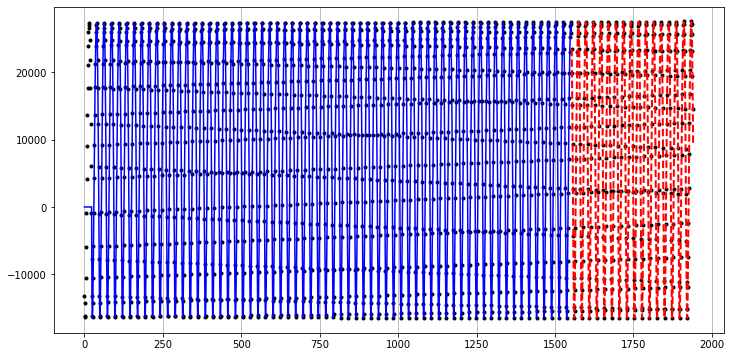

In [26]:
#ARIMA PLAYGROUD
#skip

import statsmodels.api as sm

sat_id == 239
satX = X[X['sat_id'] == sat_id]
satY = y[X['sat_id'] == sat_id]
satXtest = Xtest[Xtest['sat_id'] == sat_id]
size = int(satX.shape[0] * trainSize)
Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
ytr, yval = satY.iloc[:1*size, :-6], satY.iloc[size:, :-6]
# for i in range(nTargets):
i = 0
mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,2,24), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

nforecast = satX.shape[0] - size
predict = res.get_prediction(end=mod.nobs + nforecast)
predict.index =  ytr.iloc[:,i].index
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha=0.5)

# Graph
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(satY.iloc[:,i].reset_index(drop=True), 'k.')

# Plot
ax.plot(idx[:-nforecast], predict.predicted_mean[:-nforecast], 'blue')
ax.plot(idx[-nforecast:], predict.predicted_mean[-nforecast:], 'k--', color='red', linestyle='--', linewidth=2)
# ax.fill_between(idx, predict_ci[:, 0], predict_ci[:, 1], alpha=0.15)

In [14]:
satXtest[satXtest.sat_id>236].sat_id.iloc[0]

239

In [9]:
import statsmodels.api as sm

trainSize = 0.8
submissionValid = train.copy()[['id', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
smp = []
nTargets = 6
for sat_id in tqdm(Xtest['sat_id'].unique()):
    satX = X[X['sat_id'] == sat_id]
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id]
    size = int(satX.shape[0] * trainSize)
    Xtr, Xval = satX.iloc[:size, :], satX.iloc[size:, :]
    ytr, yval = satY.iloc[:1*size, :-6], satY.iloc[size:, :-6]
    smp_sat = []
    for i in range(nTargets):
        try:
            mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,1,24), simple_differencing=True)
            res = mod.fit(disp=False)
        except Exception as e:
            print()
            try:
                mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,0,24), simple_differencing=True)
                res = mod.fit(disp=False)
            except Exception as e:
                mod = sm.tsa.statespace.SARIMAX(ytr.iloc[:,i], order=(0,0,0), seasonal_order=(1,0,2,24), simple_differencing=True)
                res = mod.fit(disp=False)
        nforecast = satX.shape[0] - size
        pred = res.get_forecast(steps = nforecast)
        ypred = pred.predicted_mean
        assert size+len(ypred) == satY.shape[0]
        assert len(ypred) == yval.iloc[:, i].shape[0]
        ypred.index = yval.iloc[:, i].index
        smp.append(smape(ypred, yval.iloc[:, i]))
        smp_sat.append(smape(ypred, yval.iloc[:, i]))   
    print(sat_id, 100*(1- np.mean(smp_sat)))
print(100*(1- np.mean(smp)))

  0%|          | 1/300 [00:06<31:54,  6.40s/it]

1 94.0235880002222


  1%|          | 2/300 [00:08<24:49,  5.00s/it]

2 99.35651246379926


  1%|          | 3/300 [00:09<19:26,  3.93s/it]

3 98.76495307627228


  1%|▏         | 4/300 [00:11<16:47,  3.40s/it]

4 98.62692434858108


  2%|▏         | 5/300 [00:16<18:09,  3.69s/it]

6 93.7751263859991


  2%|▏         | 6/300 [00:20<19:29,  3.98s/it]

9 97.64071291568038


  2%|▏         | 7/300 [00:24<18:32,  3.80s/it]

16 96.70995420557732


  3%|▎         | 8/300 [00:25<14:35,  3.00s/it]

20 82.81937861992684


  3%|▎         | 9/300 [00:26<12:39,  2.61s/it]

22 77.38825718482487


  3%|▎         | 10/300 [00:38<25:35,  5.29s/it]

24 98.25019785297616


  4%|▎         | 11/300 [00:41<21:53,  4.55s/it]

25 88.29818726011956


  4%|▍         | 12/300 [00:42<17:38,  3.68s/it]

26 90.36336826435851


  4%|▍         | 13/300 [00:46<17:29,  3.66s/it]

27 97.3989746215291


  5%|▍         | 14/300 [00:51<19:10,  4.02s/it]

28 88.13025484952112


  5%|▌         | 15/300 [01:00<25:49,  5.44s/it]

29 99.03071583847644


  5%|▌         | 16/300 [01:01<19:54,  4.20s/it]

32 99.1263118767039


  6%|▌         | 17/300 [01:29<53:53, 11.43s/it]

34 99.39943033813408


  6%|▌         | 18/300 [01:33<42:42,  9.09s/it]

35 81.44391115090173


  6%|▋         | 19/300 [02:06<1:15:56, 16.22s/it]

36 94.28279245442529


  7%|▋         | 20/300 [02:16<1:06:43, 14.30s/it]

37 42.2465515799069


  7%|▋         | 21/300 [02:17<49:09, 10.57s/it]  

38 75.9346139484945


  7%|▋         | 22/300 [02:29<50:52, 10.98s/it]

39 99.62497818002572


  8%|▊         | 23/300 [02:55<1:11:05, 15.40s/it]

40 99.58011144908299


  8%|▊         | 24/300 [02:59<54:23, 11.82s/it]  

41 94.23801207014643


  8%|▊         | 25/300 [03:12<57:03, 12.45s/it]

42 99.49666412777826


  9%|▊         | 26/300 [04:14<2:03:55, 27.14s/it]

44 92.24861228719084


  9%|▉         | 27/300 [04:16<1:28:41, 19.49s/it]

45 77.8175466149974


  9%|▉         | 28/300 [04:33<1:25:37, 18.89s/it]

49 96.59746317778378


 10%|▉         | 29/300 [05:05<1:42:57, 22.80s/it]

51 99.72404761485409


 10%|█         | 30/300 [05:07<1:15:07, 16.70s/it]

52 94.49725893493522


 10%|█         | 31/300 [05:51<1:50:41, 24.69s/it]

53 97.74763624199224


 11%|█         | 32/300 [06:23<2:00:35, 27.00s/it]

54 91.64008730024987


 11%|█         | 33/300 [07:01<2:14:34, 30.24s/it]

57 99.06645793230194


 11%|█▏        | 34/300 [07:05<1:39:15, 22.39s/it]

59 95.60104125378324


 12%|█▏        | 35/300 [07:08<1:13:26, 16.63s/it]

63 88.38560262199418


 12%|█▏        | 36/300 [07:11<55:06, 12.52s/it]  

64 96.9810074330507


 12%|█▏        | 37/300 [08:21<2:10:39, 29.81s/it]

68 96.80261602657498


 13%|█▎        | 38/300 [08:25<1:35:37, 21.90s/it]

70 98.00095818358514


 13%|█▎        | 39/300 [08:38<1:23:57, 19.30s/it]

75 98.38254457485446


 13%|█▎        | 40/300 [08:40<1:01:03, 14.09s/it]

82 77.73207680138559


 14%|█▎        | 41/300 [08:41<44:21, 10.28s/it]  

84 99.21762742085214


 14%|█▍        | 42/300 [08:44<34:55,  8.12s/it]

86 95.41252409222405


 14%|█▍        | 43/300 [08:52<34:34,  8.07s/it]

89 99.65428858719457


 15%|█▍        | 44/300 [08:58<31:09,  7.30s/it]

90 78.1056973508484


 15%|█▌        | 45/300 [09:11<39:05,  9.20s/it]

91 98.47578119807835


 15%|█▌        | 46/300 [09:14<29:58,  7.08s/it]

92 92.69624301410406


 16%|█▌        | 47/300 [09:37<50:22, 11.95s/it]

93 99.77652328902853


 16%|█▌        | 48/300 [09:43<43:14, 10.30s/it]

96 99.4975643784972


 16%|█▋        | 49/300 [09:45<32:33,  7.78s/it]

98 91.15587292620219


 17%|█▋        | 50/300 [09:47<25:18,  6.07s/it]

100 96.07601048502397


 17%|█▋        | 51/300 [09:49<19:54,  4.80s/it]

101 98.28832778307932


 17%|█▋        | 52/300 [09:58<25:22,  6.14s/it]

102 97.55573182942513


 18%|█▊        | 53/300 [10:09<30:51,  7.49s/it]

105 99.75287954851416


 18%|█▊        | 54/300 [10:12<24:48,  6.05s/it]

106 96.50359548838357


 18%|█▊        | 55/300 [10:15<20:51,  5.11s/it]

109 91.35561963631397


 19%|█▊        | 56/300 [10:22<23:27,  5.77s/it]

110 98.65382201822128


 19%|█▉        | 57/300 [10:25<20:04,  4.96s/it]

112 88.68643472372788


 19%|█▉        | 58/300 [10:29<18:35,  4.61s/it]

113 93.86134433273115


 20%|█▉        | 59/300 [10:39<25:11,  6.27s/it]

114 94.01337653353427


 20%|██        | 60/300 [10:47<26:42,  6.68s/it]

117 99.41931346528466


 20%|██        | 61/300 [10:49<21:36,  5.42s/it]

118 97.51165590978322


 21%|██        | 62/300 [10:56<22:50,  5.76s/it]

120 98.97808305813885


 21%|██        | 63/300 [11:24<49:49, 12.61s/it]

121 98.91713174072162


 21%|██▏       | 64/300 [11:28<38:39,  9.83s/it]

123 88.7566301434739


 22%|██▏       | 65/300 [11:31<31:06,  7.94s/it]

124 97.0566709506645


 22%|██▏       | 66/300 [11:34<24:53,  6.38s/it]

125 95.11160452566524


 22%|██▏       | 67/300 [11:36<19:40,  5.07s/it]

126 93.92033808834671


 23%|██▎       | 68/300 [11:42<20:59,  5.43s/it]

127 77.31515831327748


 23%|██▎       | 69/300 [11:48<21:25,  5.56s/it]

128 98.16995957040608


 23%|██▎       | 70/300 [12:02<31:18,  8.17s/it]

130 99.35962629251028


 24%|██▎       | 71/300 [12:22<44:02, 11.54s/it]

132 99.19082694795911


 24%|██▍       | 72/300 [12:24<33:01,  8.69s/it]

133 99.07580976131338


 24%|██▍       | 73/300 [13:34<1:42:26, 27.08s/it]

135 96.9560966946863


 25%|██▍       | 74/300 [14:16<1:59:22, 31.69s/it]

138 99.4198786148084


 25%|██▌       | 75/300 [14:37<1:46:20, 28.36s/it]

142 97.28285299996747


 25%|██▌       | 76/300 [14:51<1:30:32, 24.25s/it]

143 99.68481053531531


 26%|██▌       | 77/300 [15:02<1:15:08, 20.22s/it]

144 99.74770117610113


 26%|██▌       | 78/300 [15:41<1:35:45, 25.88s/it]

145 99.34631119116429


 26%|██▋       | 79/300 [15:43<1:08:54, 18.71s/it]

149 96.7739802611698


 27%|██▋       | 80/300 [15:45<49:27, 13.49s/it]  

151 81.35277698314428


 27%|██▋       | 81/300 [16:15<1:07:22, 18.46s/it]

152 99.79217150658101


 27%|██▋       | 82/300 [16:17<49:14, 13.55s/it]  

153 86.95762396586564


 28%|██▊       | 83/300 [16:22<39:58, 11.06s/it]

155 96.60676360432832


 28%|██▊       | 84/300 [16:54<1:01:56, 17.20s/it]

156 92.65872068789265


 28%|██▊       | 85/300 [17:01<50:43, 14.16s/it]  

158 99.01305524919208


 29%|██▊       | 86/300 [17:25<1:01:00, 17.11s/it]

159 86.57821793852371


 29%|██▉       | 87/300 [17:37<56:06, 15.81s/it]  

160 98.77716045227359


 29%|██▉       | 88/300 [17:42<44:24, 12.57s/it]

162 88.15707697693222


 30%|██▉       | 89/300 [17:46<34:18,  9.76s/it]

164 98.21044664190201


 30%|███       | 90/300 [17:55<33:29,  9.57s/it]

165 99.74490707347825


 30%|███       | 91/300 [18:01<29:42,  8.53s/it]

166 87.63060038250597


 31%|███       | 92/300 [18:04<24:32,  7.08s/it]

169 98.11847843244679


 31%|███       | 93/300 [18:28<41:29, 12.03s/it]

170 94.09211891655744


 31%|███▏      | 94/300 [18:39<39:40, 11.56s/it]

172 96.77404474411061


 32%|███▏      | 95/300 [18:41<30:27,  8.91s/it]

173 98.24388394546568


 32%|███▏      | 96/300 [18:43<22:59,  6.76s/it]

177 98.76120190012165


 32%|███▏      | 97/300 [18:51<24:02,  7.11s/it]

178 99.63852198162229


 33%|███▎      | 98/300 [19:18<44:26, 13.20s/it]

183 98.83484150359688


 33%|███▎      | 99/300 [19:38<50:41, 15.13s/it]

186 94.96595230231794


 33%|███▎      | 100/300 [20:06<1:03:44, 19.12s/it]

187 93.10350755236718


 34%|███▎      | 101/300 [20:08<45:55, 13.85s/it]  

188 99.41967483491806


 34%|███▍      | 102/300 [20:20<43:36, 13.21s/it]

191 96.80245602032


 34%|███▍      | 103/300 [20:28<38:55, 11.85s/it]

193 96.87007029341926


 35%|███▍      | 104/300 [20:30<28:19,  8.67s/it]

194 90.10570297315074


 35%|███▌      | 105/300 [20:31<20:58,  6.46s/it]

195 89.6478880903627


 35%|███▌      | 106/300 [20:38<21:11,  6.56s/it]

197 99.31373345859596


 36%|███▌      | 107/300 [20:50<27:06,  8.43s/it]

203 98.14843188889779


 36%|███▌      | 108/300 [21:01<28:44,  8.98s/it]

205 98.49037096616014


 36%|███▋      | 109/300 [21:04<23:25,  7.36s/it]

206 93.64050210562365


 37%|███▋      | 110/300 [22:01<1:10:24, 22.23s/it]

207 96.98172859957967


 37%|███▋      | 111/300 [22:03<50:25, 16.01s/it]  

208 90.33597997835841


 37%|███▋      | 112/300 [22:12<43:22, 13.84s/it]

209 85.73338026063618


 38%|███▊      | 113/300 [22:26<43:59, 14.11s/it]

210 98.40359008938904


 38%|███▊      | 114/300 [22:53<55:14, 17.82s/it]

211 99.07579954561508


 38%|███▊      | 115/300 [22:54<39:56, 12.95s/it]

213 76.66754044615182


 39%|███▊      | 116/300 [23:01<33:52, 11.05s/it]

219 99.03628023676877


 39%|███▉      | 117/300 [23:22<42:37, 13.98s/it]

220 99.14766037216138


 39%|███▉      | 118/300 [23:28<35:05, 11.57s/it]

222 99.21112756634514


 40%|███▉      | 119/300 [23:31<27:16,  9.04s/it]

223 87.36614573616666


 40%|████      | 120/300 [23:44<31:05, 10.37s/it]

225 93.12926116210292


 40%|████      | 121/300 [23:57<33:24, 11.20s/it]

227 99.675578794314


 41%|████      | 122/300 [24:01<26:25,  8.91s/it]

228 81.00150689369636


 41%|████      | 123/300 [24:13<28:44,  9.74s/it]

229 99.51258493282393


 41%|████▏     | 124/300 [24:15<21:48,  7.44s/it]

230 88.98635334399889


 42%|████▏     | 125/300 [24:33<31:23, 10.76s/it]

233 99.87018058459606


 42%|████▏     | 126/300 [24:36<24:05,  8.31s/it]

236 98.33126932806623


 42%|████▏     | 127/300 [26:02<1:31:42, 31.80s/it]

239 97.21734778944902


 43%|████▎     | 128/300 [26:19<1:18:22, 27.34s/it]

240 99.44394091694438


 43%|████▎     | 129/300 [26:37<1:09:43, 24.46s/it]

241 86.8704364569311


 43%|████▎     | 130/300 [26:39<50:24, 17.79s/it]  

242 99.28445092197843


 44%|████▎     | 131/300 [26:42<37:08, 13.19s/it]

243 97.06720064941248


 44%|████▍     | 132/300 [26:47<30:02, 10.73s/it]

244 86.10154960469151


 44%|████▍     | 133/300 [27:02<33:44, 12.13s/it]

245 99.541515302762


 45%|████▍     | 134/300 [27:04<24:51,  8.98s/it]

247 79.17377041603903


 45%|████▌     | 135/300 [27:05<18:30,  6.73s/it]

248 89.12527353090579


 45%|████▌     | 136/300 [27:07<14:18,  5.24s/it]

251 99.23507736678076


 46%|████▌     | 137/300 [27:08<11:05,  4.08s/it]

252 74.76987386616035


 46%|████▌     | 138/300 [27:42<34:43, 12.86s/it]

253 59.26136807822859


 46%|████▋     | 139/300 [27:57<36:20, 13.54s/it]

254 96.48145431408489


 47%|████▋     | 140/300 [28:03<30:11, 11.32s/it]

261 99.56300042281889


 47%|████▋     | 141/300 [28:25<38:22, 14.48s/it]

263 98.85793049416333


 47%|████▋     | 142/300 [28:26<27:28, 10.43s/it]

264 95.66932299924322


 48%|████▊     | 143/300 [28:28<20:41,  7.91s/it]

265 98.58224779855351


 48%|████▊     | 144/300 [28:32<17:13,  6.62s/it]

268 97.11981694504246


 48%|████▊     | 145/300 [28:34<13:40,  5.29s/it]

270 97.78749316469603


 49%|████▊     | 146/300 [28:38<12:37,  4.92s/it]

275 89.02327822879806


 49%|████▉     | 147/300 [28:40<10:14,  4.02s/it]

277 80.47965670924395


 49%|████▉     | 148/300 [28:41<08:20,  3.29s/it]

278 99.6088124647397


 50%|████▉     | 149/300 [28:57<17:57,  7.13s/it]

281 98.41932184243865


 50%|█████     | 150/300 [29:24<32:32, 13.02s/it]

284 92.8266429949421


 50%|█████     | 151/300 [29:33<29:16, 11.79s/it]

288 99.71819882996736


 51%|█████     | 152/300 [29:40<25:22, 10.29s/it]

292 98.29056588963923


 51%|█████     | 153/300 [29:55<28:58, 11.83s/it]

293 98.34898201470267


 51%|█████▏    | 154/300 [30:17<35:45, 14.69s/it]

294 98.6438522360257


 52%|█████▏    | 155/300 [30:35<38:24, 15.90s/it]

298 99.8043167293375


 52%|█████▏    | 156/300 [31:47<1:18:35, 32.75s/it]

299 98.24943628369343


 52%|█████▏    | 157/300 [31:49<55:34, 23.32s/it]  

301 96.28211221417178


 53%|█████▎    | 158/300 [31:57<44:24, 18.76s/it]

304 99.6814665744702


 53%|█████▎    | 159/300 [32:13<42:15, 17.98s/it]

306 97.83706410803998


 53%|█████▎    | 160/300 [32:22<35:25, 15.18s/it]

309 91.93871821692325


 54%|█████▎    | 161/300 [32:24<26:30, 11.45s/it]

310 73.72142277940658


 54%|█████▍    | 162/300 [33:17<54:33, 23.72s/it]

312 86.98244622587828


 54%|█████▍    | 163/300 [33:27<44:44, 19.60s/it]

314 98.67868920080844


 55%|█████▍    | 164/300 [33:36<37:17, 16.45s/it]

316 96.63953454926943


 55%|█████▌    | 165/300 [33:45<32:23, 14.40s/it]

319 99.44779510269967


 55%|█████▌    | 166/300 [33:55<28:46, 12.88s/it]

324 99.41098243467842


 56%|█████▌    | 167/300 [34:04<25:53, 11.68s/it]

326 96.75477886044555


 56%|█████▌    | 168/300 [34:15<25:11, 11.45s/it]

332 98.99265310307194


 56%|█████▋    | 169/300 [34:22<22:21, 10.24s/it]

333 93.78467186610071


 57%|█████▋    | 170/300 [35:12<48:02, 22.17s/it]

342 98.1969285534344


 57%|█████▋    | 171/300 [35:24<41:12, 19.17s/it]

343 99.81815449868763


 57%|█████▋    | 172/300 [35:59<50:41, 23.76s/it]

344 98.7847111145387


 58%|█████▊    | 173/300 [36:04<38:21, 18.12s/it]

347 95.78341796226616


 58%|█████▊    | 174/300 [36:06<28:10, 13.42s/it]

348 91.48757015641246


 58%|█████▊    | 175/300 [36:20<28:15, 13.56s/it]

349 99.73692405091539


 59%|█████▊    | 176/300 [36:34<28:09, 13.63s/it]

356 97.44065252160354


 59%|█████▉    | 177/300 [36:42<24:32, 11.97s/it]

357 99.48671629264496


 59%|█████▉    | 178/300 [37:14<36:46, 18.09s/it]

358 93.60914549522722


 60%|█████▉    | 179/300 [37:22<29:55, 14.84s/it]

359 98.91263136999466


 60%|██████    | 180/300 [37:26<23:21, 11.68s/it]

362 87.76536444799677


 60%|██████    | 181/300 [37:28<17:23,  8.77s/it]

363 93.34366790781056


 61%|██████    | 182/300 [37:39<18:43,  9.52s/it]

372 40.93826302693419


 61%|██████    | 183/300 [37:55<22:25, 11.50s/it]

373 95.10350732801413


 61%|██████▏   | 184/300 [37:56<16:18,  8.43s/it]

375 98.29436184546061


 62%|██████▏   | 185/300 [38:05<16:14,  8.48s/it]

377 96.89052875324352


 62%|██████▏   | 186/300 [38:08<12:59,  6.84s/it]

380 97.1722233698142


 62%|██████▏   | 187/300 [38:10<10:14,  5.44s/it]

382 99.3616183891403


 63%|██████▎   | 188/300 [38:26<15:46,  8.45s/it]

384 99.10931948405167


 63%|██████▎   | 189/300 [38:29<12:32,  6.78s/it]

385 98.59747363246497


 63%|██████▎   | 190/300 [39:12<32:42, 17.84s/it]

387 96.5199299751854


 64%|██████▎   | 191/300 [39:24<28:54, 15.92s/it]

389 98.62828246539303


 64%|██████▍   | 192/300 [39:27<21:41, 12.05s/it]

390 93.16437088654308


 64%|██████▍   | 193/300 [39:28<15:32,  8.72s/it]

391 80.78981431075908


 65%|██████▍   | 194/300 [39:33<13:30,  7.64s/it]

392 94.55571028438405


 65%|██████▌   | 195/300 [39:57<22:09, 12.67s/it]

393 99.7640743581542


 65%|██████▌   | 196/300 [40:02<18:07, 10.46s/it]

395 99.14384009807091


 66%|██████▌   | 197/300 [40:07<15:03,  8.77s/it]

396 88.08469672822633


 66%|██████▌   | 198/300 [40:15<14:12,  8.36s/it]

399 98.9719073432571


 66%|██████▋   | 199/300 [40:31<17:52, 10.62s/it]

400 99.77655353612711


 67%|██████▋   | 200/300 [40:36<15:07,  9.07s/it]

407 80.56189864108553


 67%|██████▋   | 201/300 [40:38<11:29,  6.96s/it]

409 98.72175283580258


 67%|██████▋   | 202/300 [40:46<11:47,  7.22s/it]

411 99.0162287351054


 68%|██████▊   | 203/300 [40:58<14:05,  8.72s/it]

412 97.47331374680194


 68%|██████▊   | 204/300 [41:00<10:41,  6.68s/it]

415 78.91122883044343


 68%|██████▊   | 205/300 [41:02<08:19,  5.25s/it]

416 78.86872806139134


 69%|██████▊   | 206/300 [41:18<13:07,  8.38s/it]

417 99.81846822260373


 69%|██████▉   | 207/300 [41:20<10:22,  6.69s/it]

418 90.33342080632048


 69%|██████▉   | 208/300 [41:48<20:02, 13.07s/it]

419 99.54293126171272


 70%|██████▉   | 209/300 [41:54<16:26, 10.84s/it]

422 77.4550949729954


 70%|███████   | 210/300 [42:30<27:32, 18.37s/it]

423 97.92257676894639


 70%|███████   | 211/300 [42:52<28:58, 19.53s/it]

424 99.52632220272145


 71%|███████   | 212/300 [43:02<24:12, 16.50s/it]

426 99.78597874540685


 71%|███████   | 213/300 [43:18<23:59, 16.55s/it]

428 99.81067001246622


 71%|███████▏  | 214/300 [43:28<20:52, 14.56s/it]

435 94.662331008815


 72%|███████▏  | 215/300 [43:56<26:10, 18.47s/it]

436 98.21942291778647


 72%|███████▏  | 216/300 [43:58<18:59, 13.57s/it]

437 94.93001272127245


 72%|███████▏  | 217/300 [44:00<14:08, 10.22s/it]

438 87.41133834277667


 73%|███████▎  | 218/300 [44:02<10:24,  7.61s/it]

440 98.52388084975603


 73%|███████▎  | 219/300 [44:14<11:56,  8.84s/it]

443 86.71644551232961


 73%|███████▎  | 220/300 [44:27<13:49, 10.37s/it]

446 99.42934794491802


 74%|███████▎  | 221/300 [44:31<11:08,  8.47s/it]

448 93.18026881127889


 74%|███████▍  | 222/300 [44:42<11:57,  9.19s/it]

449 99.70451424855396


 74%|███████▍  | 223/300 [44:46<09:43,  7.58s/it]

450 77.62915395576782


 75%|███████▍  | 224/300 [44:50<08:01,  6.33s/it]

452 92.72194554596689


 75%|███████▌  | 225/300 [44:51<06:01,  4.82s/it]

454 90.33585243291714


 75%|███████▌  | 226/300 [45:00<07:27,  6.04s/it]

455 98.41496931024868


 76%|███████▌  | 227/300 [45:21<12:50, 10.56s/it]

456 96.10043244291982


 76%|███████▌  | 228/300 [45:26<10:44,  8.95s/it]

457 98.86428567859467


 76%|███████▋  | 229/300 [45:49<15:27, 13.07s/it]

460 96.07304830327737


 77%|███████▋  | 230/300 [46:11<18:23, 15.77s/it]

462 98.97577602139083


 77%|███████▋  | 231/300 [46:45<24:18, 21.14s/it]

464 94.97100280186973


 77%|███████▋  | 232/300 [47:21<29:09, 25.72s/it]

465 98.9069416428012


 78%|███████▊  | 233/300 [47:23<20:43, 18.56s/it]

466 94.09360344655788


 78%|███████▊  | 234/300 [47:28<15:53, 14.44s/it]

467 96.65409162103809


 78%|███████▊  | 235/300 [47:30<11:43, 10.83s/it]

468 98.32026425727177


 79%|███████▊  | 236/300 [47:37<10:09,  9.53s/it]

470 93.67192864742934


 79%|███████▉  | 237/300 [47:43<09:08,  8.70s/it]

471 90.43968014179005


 79%|███████▉  | 238/300 [47:51<08:49,  8.54s/it]

473 55.22788505750811


 80%|███████▉  | 239/300 [48:28<17:11, 16.92s/it]

474 93.53633209772413


 80%|████████  | 240/300 [48:36<14:16, 14.27s/it]

475 97.81584328598998


 80%|████████  | 241/300 [48:41<11:15, 11.45s/it]

476 85.80353340156826


 81%|████████  | 242/300 [48:43<08:13,  8.50s/it]

477 77.43538437541724


 81%|████████  | 243/300 [49:18<15:40, 16.50s/it]

479 96.81507217404882


 81%|████████▏ | 244/300 [49:19<11:08, 11.94s/it]

480 99.37046770890099


 82%|████████▏ | 245/300 [49:21<08:09,  8.90s/it]

481 76.5018516071551


 82%|████████▏ | 246/300 [49:24<06:28,  7.20s/it]

482 91.9871631988677


 82%|████████▏ | 247/300 [49:26<04:53,  5.53s/it]

483 98.85454893108768


 83%|████████▎ | 248/300 [49:30<04:25,  5.10s/it]

486 86.29389776229488


 83%|████████▎ | 249/300 [49:47<07:18,  8.61s/it]

488 99.14584330987653


 83%|████████▎ | 250/300 [51:13<26:42, 32.06s/it]

489 94.2316123231645


 84%|████████▎ | 251/300 [51:17<19:10, 23.47s/it]

491 93.38865006968977


 84%|████████▍ | 252/300 [51:20<13:50, 17.29s/it]

495 96.26970683977862


 84%|████████▍ | 253/300 [51:21<09:52, 12.60s/it]

498 83.69769851982406


 85%|████████▍ | 254/300 [51:36<10:12, 13.33s/it]

499 98.57456415302515


 85%|████████▌ | 255/300 [51:39<07:37, 10.16s/it]

502 88.5466509510384


 85%|████████▌ | 256/300 [51:40<05:24,  7.38s/it]

504 80.51478347610522


 86%|████████▌ | 257/300 [51:42<04:05,  5.72s/it]

505 99.48365491071127


 86%|████████▌ | 258/300 [51:52<04:56,  7.06s/it]

506 99.70019683636964


 86%|████████▋ | 259/300 [51:53<03:40,  5.37s/it]

508 76.06893564052713


 87%|████████▋ | 260/300 [52:02<04:18,  6.47s/it]

509 98.51389823871204


 87%|████████▋ | 261/300 [52:15<05:25,  8.36s/it]

510 94.8922575840619


 87%|████████▋ | 262/300 [52:22<04:55,  7.79s/it]

511 87.85763830815493


 88%|████████▊ | 263/300 [52:40<06:47, 11.02s/it]

514 55.45746951695036


 88%|████████▊ | 264/300 [52:41<04:43,  7.87s/it]

515 67.41107206739846


 88%|████████▊ | 265/300 [52:47<04:22,  7.51s/it]

516 97.36910599740028


 89%|████████▊ | 266/300 [52:53<03:55,  6.91s/it]

517 93.56215359497473


 89%|████████▉ | 267/300 [53:07<04:59,  9.07s/it]

519 99.43952783905613


 89%|████████▉ | 268/300 [53:18<05:05,  9.53s/it]

522 97.03315902419402


 90%|████████▉ | 269/300 [53:46<07:53, 15.29s/it]

523 36.547626940653586


 90%|█████████ | 270/300 [53:47<05:27, 10.90s/it]

524 81.4818305680508


 90%|█████████ | 271/300 [53:51<04:19,  8.96s/it]

528 96.00292804940432


 91%|█████████ | 272/300 [53:53<03:06,  6.67s/it]

536 86.59213694086161


 91%|█████████ | 273/300 [54:06<03:55,  8.71s/it]

537 99.84861182443613


 91%|█████████▏| 274/300 [54:08<02:49,  6.52s/it]

539 99.4161620837089


 92%|█████████▏| 275/300 [54:10<02:08,  5.15s/it]

542 96.6085370384366


 92%|█████████▏| 276/300 [54:12<01:45,  4.39s/it]

543 93.49209971410532


 92%|█████████▏| 277/300 [54:16<01:36,  4.18s/it]

544 91.59010060699931


 93%|█████████▎| 278/300 [54:26<02:09,  5.91s/it]

547 99.70780739179625


 93%|█████████▎| 279/300 [54:27<01:35,  4.55s/it]

548 87.23839500696238


 93%|█████████▎| 280/300 [54:29<01:11,  3.58s/it]

549 79.87567685135856


 94%|█████████▎| 281/300 [54:33<01:12,  3.80s/it]

550 87.85125897967859


 94%|█████████▍| 282/300 [54:35<00:57,  3.18s/it]

558 87.78705828373474


 94%|█████████▍| 283/300 [54:37<00:49,  2.94s/it]

563 97.19088890024766


 95%|█████████▍| 284/300 [54:39<00:42,  2.68s/it]

565 75.0399459370322


 95%|█████████▌| 285/300 [54:51<01:22,  5.47s/it]

566 93.07359610493111


 95%|█████████▌| 286/300 [55:00<01:30,  6.50s/it]

567 99.34397005045199


 96%|█████████▌| 287/300 [55:03<01:11,  5.54s/it]

569 95.3140572636789


 96%|█████████▌| 288/300 [55:06<00:58,  4.84s/it]

572 90.75859816320482


 96%|█████████▋| 289/300 [55:08<00:43,  3.99s/it]

575 96.19778967644955


 97%|█████████▋| 290/300 [55:24<01:15,  7.56s/it]

578 99.80158212932098


 97%|█████████▋| 291/300 [55:58<02:18, 15.41s/it]

579 99.7065908902336


 97%|█████████▋| 292/300 [56:00<01:30, 11.27s/it]

580 98.86921110563301


 98%|█████████▊| 293/300 [56:21<01:40, 14.34s/it]

583 98.98581755776064


 98%|█████████▊| 294/300 [56:34<01:23, 13.99s/it]

584 84.77740754675132


 98%|█████████▊| 295/300 [56:58<01:24, 16.91s/it]

587 39.61678628151623


 99%|█████████▊| 296/300 [57:07<00:58, 14.51s/it]

588 77.35290201196415


 99%|█████████▉| 297/300 [57:30<00:50, 16.95s/it]

593 98.86164227626195


 99%|█████████▉| 298/300 [57:32<00:24, 12.45s/it]

595 92.92648725692109


100%|█████████▉| 299/300 [57:33<00:09,  9.12s/it]

596 98.29766739808814


100%|██████████| 300/300 [57:34<00:00, 11.52s/it]

597 98.75483784148814
93.0706218893105


In [155]:
res

In [10]:
ytr

,x,y,z,Vx,Vy,Vz
647101,-27735.732811,26499.319414,-69.253391,2.651839,2.774409,-0.444006
647102,-4387.821173,41000.384470,-3135.641509,3.471924,1.110594,-0.367181
647103,20722.539898,43538.366410,-5324.630523,3.228520,-0.321261,-0.226445
647104,42265.199476,37761.501208,-6527.004358,2.600048,-1.160217,-0.105790
647105,58991.128640,27453.084215,-6965.885062,1.950639,-1.587761,-0.018433
...,...,...,...,...,...,...
647388,-35839.969797,-44628.379813,6394.818760,-1.279927,2.517020,-0.113693
647389,-42685.629939,-23597.726696,5156.744150,-0.493746,3.178566,-0.227609
647390,-41613.491403,1424.421757,2993.908795,0.890506,3.509936,-0.358760
647391,-28673.007592,25558.378763,17.167210,2.593242,2.826696,-0.429249


In [10]:
nTargets = 6
for sat_id in tqdm(Xtest['sat_id'].unique()):
    satX = X[X['sat_id'] == sat_id].drop(columns = ['sat_id'])
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id].drop(columns = ['sat_id'])
    
    for i in range(nTargets):
        try:
            mod = sm.tsa.statespace.SARIMAX(satY.iloc[:, i], order=(0,0,0), seasonal_order=(1,0,1,24), simple_differencing=True)
            res = mod.fit(disp=False)
        except Exception as e:
            try:
                mod = sm.tsa.statespace.SARIMAX(satY.iloc[:, i], order=(0,0,0), seasonal_order=(1,0,0,24), simple_differencing=True)
                res = mod.fit(disp=False)
            except Exception as e:
                mod = sm.tsa.statespace.SARIMAX(satY.iloc[:, i], order=(0,0,0), seasonal_order=(1,0,2,24), simple_differencing=True)
                res = mod.fit(disp=False)
        nforecast = satXtest.shape[0]
        pred = res.get_forecast(steps = nforecast)
        ypred = pred.predicted_mean
        assert len(ypred) == satXtest.iloc[:, i].shape[0]
        ypred.index = satXtest.iloc[:, i].index
        submission.loc[satXtest.index, submission.columns[i+1]] = ypred

100%|██████████| 300/300 [1:06:46<00:00, 13.36s/it]


In [12]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
nTargets = 6
for sat_id in tqdm(Xtest['sat_id'].unique()):
    satX = X[X['sat_id'] == sat_id].drop(columns = ['sat_id'])
    satY = y[X['sat_id'] == sat_id]
    satXtest = Xtest[Xtest['sat_id'] == sat_id].drop(columns = ['sat_id'])
    
    for i in range(nTargets):
        model1 = CatBoostRegressor(iterations=200,
                          learning_rate=0.3,
                          depth=5,
                          verbose=False)
        model1.fit(satX, satY.iloc[:, i])
        model2 = Ridge()
        model2.fit(satX, satY.iloc[:, i])
        ypred = (2 * model1.predict(satXtest) + model2.predict(satXtest)) / 3
        submission.loc[satXtest.index, submission.columns[i+1]] = ypred

100%|██████████| 300/300 [11:41<00:00,  2.34s/it]


In [11]:
submission.to_csv('submission_sarima.csv', index = None)

In [21]:
y

,x,y,z,Vx,Vy,Vz,L2norm,phi,theta
0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,26080.000000,-0.976977,2.489472
1,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,26686.896582,-0.152090,2.729408
2,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,28338.043990,0.766218,2.596977
3,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,30651.371610,1.153792,2.313120
4,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,33244.665434,1.342582,2.036848
...,...,...,...,...,...,...,...,...,...
649907,-21721.485878,-14048.557595,5277.807430,-1.351754,3.373418,0.004995,26401.518338,0.574093,1.369535
649908,-23176.890569,-8712.016936,5153.371350,-0.575955,3.764450,-0.175109,25290.803305,0.359553,1.365595
649909,-23363.044794,-2906.071320,4747.247386,0.351381,3.992943,-0.372198,24016.941319,0.123752,1.371824
649910,-22058.020262,3074.894039,4038.853542,1.421085,3.984793,-0.578849,22634.565805,-0.138508,1.391398
